In [39]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


cali_housing = fetch_california_housing(as_frame=True)
#x=cali_housing.data
#y=cali_housing.target

df=cali_housing.frame

###外れ値処理(多変量連関図で確認しながら標準偏差で外れ値を処理)
ar_std=df['AveRooms'].std()
ab_std=df['AveBedrms'].std()
pop_std=df['Population'].std()
ao_std=df['AveOccup'].std()

ar_mean=df['AveRooms'].mean()
ab_mean=df['AveBedrms'].mean()
pop_mean=df['Population'].mean()
ao_mean=df['AveOccup'].mean()

limit_low=ar_mean - 1*ab_std
limit_high=ar_mean + 1*ab_std

limit_low1=ab_mean - 1*ab_std
limit_high1=ab_mean + 1*ab_std

limit_low2=pop_mean - 1*pop_std
limit_high2=pop_mean + 1*pop_std

limit_low3=ao_mean - 0.5*ao_std
limit_high3=ao_mean + 0.5*ao_std

newdf=df.query('@limit_low < AveRooms < @limit_high')
newdf1=newdf.query('@limit_low1 < AveBedrms < @limit_high1')
newdf2=newdf1.query('@limit_low2 < Population < @limit_high2')
newdf3=newdf2.query('@limit_low3 < AveOccup < @limit_high3')

#正規化(Max-Min法)
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

df_minmax_norm = minmax_norm(newdf3)
#入力因子をxに代入
x=df_minmax_norm.iloc[:,:8]
#出力因子をyに代入
y=df_minmax_norm.iloc[:,8:9]

# 全体データから未知データを生成
x_know,x_unknown,y_know,y_unknown=train_test_split(x,y,test_size=0.2)
# 既知データから訓練データとテストデータに分割
x_t,x_test,y_t,y_test=train_test_split(x_know,y_know,test_size=0.2)
x_train,x_transfer,y_train,y_transfer=train_test_split(x_t,y_t,test_size=0.2)

print(f"unknown:{x_unknown.shape} test:{x_test.shape} train:{x_train.shape} x_transfer:{x_transfer.shape}")
print(f"unknown:{y_unknown.shape} test:{y_test.shape} train:{y_train.shape} x_transfer:{y_transfer.shape}")
x_transfer2=x_transfer
y_transfer2=y_transfer

unknown:(1107, 8) test:(886, 8) train:(2832, 8) x_transfer:(708, 8)
unknown:(1107, 1) test:(886, 1) train:(2832, 1) x_transfer:(708, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)


# データをPyTorchのTensorに変換
train_x = torch.FloatTensor(x_train.values)
train_y = torch.FloatTensor(y_train.values)

val_x = torch.FloatTensor(x_test.values)
val_y = torch.FloatTensor(y_test.values)

# GPUが利用可能ならGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データセットとデータローダーの作成
dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
valdataset = TensorDataset(val_x, val_y)
valdataloader = DataLoader(valdataset, batch_size=10, shuffle=True)





# モデルの定義
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        output = self.regression(x)
        return output

# モデル、損失関数、オプティマイザの初期化
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# トレーニングループ
num_epochs = 100
train_losses = []  # トレーニングの損失を保存するリスト
val_losses = []    # 検証の損失を保存するリスト

for epoch in range(num_epochs):
    model.train()  # モデルをトレーニングモードに切り替え
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # 10エポックごとに損失を表示
    if (epoch + 1) % 10 == 0:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 検証ループ
    model.eval()  # モデルを評価モードに切り替え
    with torch.no_grad():
        val_loss = 0
        for val_batch_x, val_batch_y in valdataloader:
            val_batch_x, val_batch_y = val_batch_x.to(device), val_batch_y.to(device)
            val_output = model(val_batch_x)
            val_loss += criterion(val_output, val_batch_y).item()
        val_loss /= len(valdataloader)
        val_losses.append(val_loss)

        # 10エポックごとに検証の損失を表示
        if (epoch + 1) % 10 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}')

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### TIPS
Loss関数にMAEを使用するとき
~~~python
criterion = nn.L1Loss() #MAE
~~~

Loss関数にRMSEを使用するとき
~~~python
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()
~~~

最適化アルゴリズムにAdamを使用するとき

~~~python
optimizer = optim.Adam(model.parameters(), lr=0.001)
~~~


# 推論

In [ ]:
x_un = torch.FloatTensor(x_unknown.values)
y_un = torch.FloatTensor(y_unknown.values)

# モデルを評価モードに切り替え
model.eval()

# 予測
x_un = x_un.to(device)
predicted_output = model(x_un)
pre_result = predicted_output.cpu().detach().numpy()

# RMSEの計算
rmse = np.sqrt(mean_squared_error(y_un, pre_result))
print(f'RMSE: {rmse}')

# 散布図のプロット
plt.scatter(y_un, pre_result, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [ ]:
# モデルの保存
torch.save(model.state_dict(), 'model.pth')


### TIPS
モデルの読み込み
~~~python
model.load_state_dict(torch.load('model.pth'))
~~~

In [ ]:
# 新規データのTensorに変換
x_transfer = torch.FloatTensor(x_transfer.values)
y_transfer = torch.FloatTensor(y_transfer.values)

In [ ]:
model.load_state_dict(torch.load('model.pth'))

# Fine-Tuning

In [ ]:
print(model)

In [ ]:
# 勾配計算を凍結する
for param in model.parameters():
    param.requires_grad = False

# 最終層を変更する
for name, child in model.named_children():
    if name == 'regression':
        for sub_name, sub_child in child.named_children():
            if sub_name == '8':
                # 既存の層を削除して新しい層を追加
                setattr(child, sub_name, nn.Linear(16, 16))

            if sub_name == '10':
                # 既存の層を削除して新しい層を追加
                setattr(child, sub_name, nn.Linear(16, 1))

# モデルの最終層が変更されたことを確認
print(model)


In [ ]:
# モデルの最終層のみ勾配を有効にする場合（例えば、最終層のみを微調整する場合など）
for param in model.regression[6].parameters():
    param.requires_grad = True
for param in model.regression[8].parameters():
    param.requires_grad = True
for param in model.regression[10].parameters():
    param.requires_grad = True

model.to(device)

In [ ]:
trans_dataset = TensorDataset(x_transfer, y_transfer)
trans_dataloader = DataLoader(trans_dataset, batch_size=10, shuffle=True)
#valdataset = TensorDataset(val_x, val_y)
#valdataloader = DataLoader(valdataset, batch_size=10, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# トレーニングループ
num_epochs = 200
train_losses = []  # トレーニングの損失を保存するリスト
val_losses = []    # 検証の損失を保存するリスト

for epoch in range(num_epochs):
    model.train()  # モデルをトレーニングモードに切り替え
    for batch_x, batch_y in trans_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # 10エポックごとに損失を表示
    if (epoch + 1) % 10 == 0:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 検証ループ
    model.eval()  # モデルを評価モードに切り替え
    with torch.no_grad():
        val_loss = 0
        for val_batch_x, val_batch_y in valdataloader:
            val_batch_x, val_batch_y = val_batch_x.to(device), val_batch_y.to(device)
            val_output = model(val_batch_x)
            val_loss += criterion(val_output, val_batch_y).item()
        val_loss /= len(valdataloader)
        val_losses.append(val_loss)

        # 10エポックごとに検証の損失を表示
        if (epoch + 1) % 10 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}')

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# モデルを評価モードに切り替え
model.eval()

# 予測
x_un = x_un.to(device)
predicted_output = model(x_un)
pre_result = predicted_output.cpu().detach().numpy()

# RMSEの計算
rmse = np.sqrt(mean_squared_error(y_un, pre_result))
print(f'RMSE: {rmse}')

# 散布図のプロット
plt.scatter(y_un, pre_result, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

# Tensorflowで記述した場合

Epoch 1/100
284/284 [==============================] - 3s 6ms/step - loss: 0.0440 - val_loss: 0.0338
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0342 - val_loss: 0.0272
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0252 - val_loss: 0.0205
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0205 - val_loss: 0.0181
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 6/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 7/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 8/100
284/284 [==============================] - 1s 4ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 9/100
284/284 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 10/100
284/284 [==============================] - 2s 7ms/step - loss: 0.0152 - val_lo

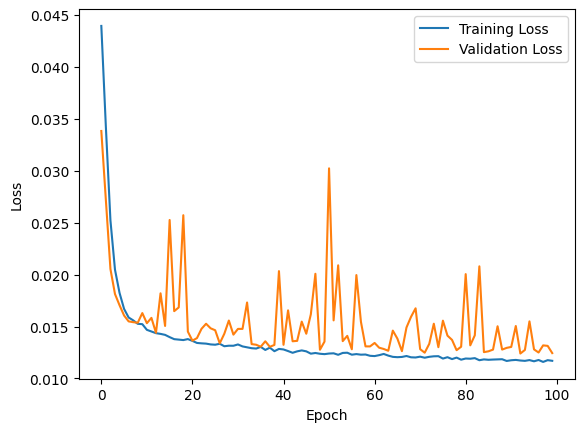

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
# TensorFlowのランダムシードの固定
tf.random.set_seed(fix_seed)

# モデルの定義
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.regression = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1)
        ])

    def call(self, x):
        return self.regression(x)

# GPU上でモデルを構築
with tf.device('/GPU:0'):
    model_tf = MLP()

# モデル、損失関数、オプティマイザの初期化
criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate=0.01)

# データセットの作成
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_x)).batch(10)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(10)

# モデルのコンパイル
model_tf.compile(optimizer=optimizer, loss=criterion)

# トレーニング
hist = model_tf.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    verbose=1)

# トレーニングと検証の損失履歴を取得
train_losses = hist.history['loss']
val_losses = hist.history['val_loss']

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Tensorflowでの推論

RMSE: 0.10870176553726196


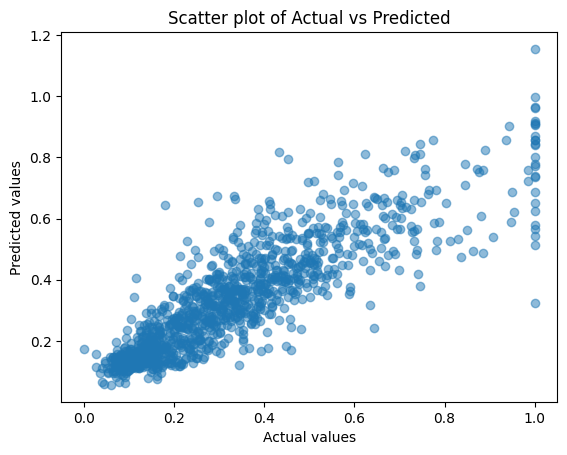

In [41]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 未知データをテンソルに変換
x_un_tf = tf.constant(x_unknown.values, dtype=tf.float32)
y_un_tf = tf.constant(y_unknown.values, dtype=tf.float32)


# TensorFlowモデルの予測
predicted_output_tf = model_tf(x_un_tf, training=False)
pre_result_tf = predicted_output_tf.numpy()

# RMSEの計算
rmse_tf = np.sqrt(mean_squared_error(y_un_tf, pre_result_tf))
print(f'RMSE: {rmse_tf}')

# 散布図のプロット
plt.scatter(y_un_tf, pre_result_tf, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# モデルを保存
model_tf.save('my_tf_mlp_model')

In [42]:
x_transfer2 = tf.constant(x_transfer2.values, dtype=tf.float32)
y_transfer2 = tf.constant(y_transfer2.values, dtype=tf.float32)
transfer_train_dataset = tf.data.Dataset.from_tensor_slices((x_transfer2, y_transfer2))
transfer_train_dataset = transfer_train_dataset.shuffle(buffer_size=len(x_transfer2)).batch(10)

Epoch 1/100
71/71 [==============================] - 1s 6ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 5/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 9/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 10/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 11/

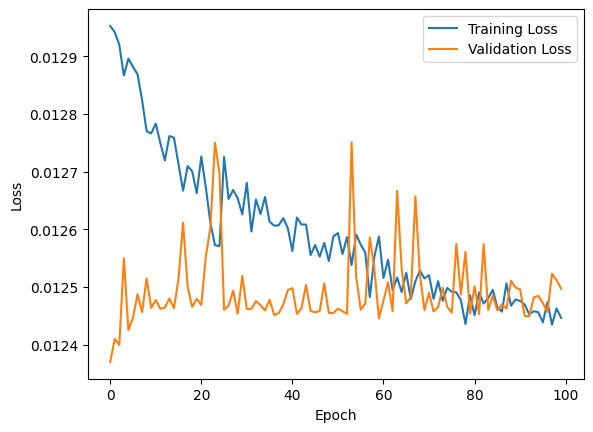

In [44]:
# モデルの定義
class reMLP(tf.keras.Model):
    def __init__(self):
        super(reMLP, self).__init__()
        self.regression = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(16, activation='relu'),  # 追加
            layers.Dense(1)
        ])

# モデルのインスタンスを作成
re_mlp_model = reMLP()

# 事前学習済みモデルのロードなどがあればここで行う
re_mlp_model = tf.keras.models.load_model('my_tf_mlp_model')

# モデル、損失関数、オプティマイザの初期化
criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate=0.01)
# モデルのコンパイル
re_mlp_model.compile(optimizer=optimizer, loss=criterion)

# Fine-tuningしたい層のインデックスを取得
fine_tune_from = -3  # 最後から3つの層をFine-tuning

# ファインチューニングのために指定した層より前は凍結
for layer in re_mlp_model.regression.layers[:fine_tune_from]:
    layer.trainable = False

# モデルのコンパイル
re_mlp_model.compile(optimizer=optimizer, loss=criterion)

# トレーニング
hist2 = re_mlp_model.fit(transfer_train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    verbose=1)

# トレーニングと検証の損失履歴を取得
train_losses2 = hist2.history['loss']
val_losses2 = hist2.history['val_loss']

# TrainとValのLossをプロット
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE: 0.10934937000274658


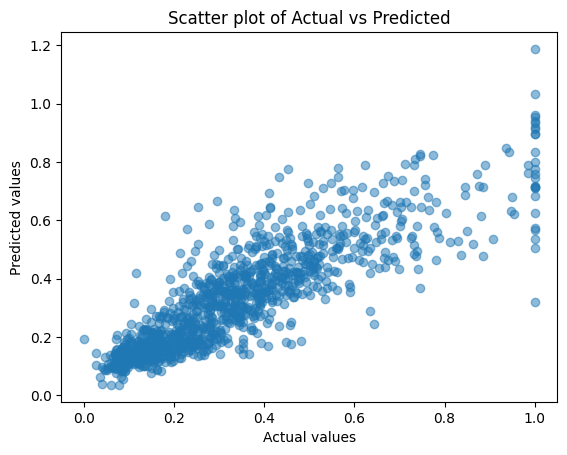

In [45]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 未知データをテンソルに変換
x_un_tf = tf.constant(x_unknown.values, dtype=tf.float32)
y_un_tf = tf.constant(y_unknown.values, dtype=tf.float32)


# TensorFlowモデルの予測
predicted_output_tf = re_mlp_model(x_un_tf, training=False)
pre_result_tf = predicted_output_tf.numpy()

# RMSEの計算
rmse_tf = np.sqrt(mean_squared_error(y_un_tf, pre_result_tf))
print(f'RMSE: {rmse_tf}')

# 散布図のプロット
plt.scatter(y_un_tf, pre_result_tf, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()